# 📰 Fake News Detection with NLP

**Goal:** Classify news texts/headlines as **Real** or **Fake**.  
**You will demonstrate:** text cleaning → tokenization → TF‑IDF features → Logistic Regression baseline → (optional) simple NN → evaluation beyond accuracy → save model → show Streamlit app code.

> **Dataset options:**  
> - Any Kaggle dataset with `text` and `label` (0/1 or fake/real).  
> - Or use the sample data generator cell to create a tiny demo dataset.

## 0) Setup

In [1]:
# !pip -q install --upgrade pip
# Keep dependencies minimal for quick Colab runs
import re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

## 1) Load Data (upload or generate demo)

In [2]:
# OPTION A: Upload your CSV with columns like: text, label
# from google.colab import files
# up = files.upload()  # then set CSV_PATH to uploaded file
CSV_PATH = None  # e.g., 'news.csv'

# OPTION B: Tiny demo dataset
def demo_df():
    texts = [
        "Government announces new healthcare reform plan.",
        "Scientists discover water on Mars!",
        "Celebrity posts shocking weight loss secret, doctors hate it!",
        "Breaking: Free iPhone for everyone, click this link now!",
        "Stock markets rise as tech companies report record earnings.",
        "Miracle cure for baldness found, pharma hides the truth!",
        "Local elections see record turnout this year.",
        "You won a lottery of $1,000,000! Claim within 24 hours."
    ]
    labels = [1,1,0,0,1,0,1,0]  # 1=Real, 0=Fake (for demo)
    return pd.DataFrame({'text': texts, 'label': labels})

if CSV_PATH:
    df = pd.read_csv(CSV_PATH)
else:
    df = demo_df()

df.head()

,text,label
0,Government announces new healthcare reform plan.,1
1,Scientists discover water on Mars!,1
2,"Celebrity posts shocking weight loss secret, d...",0
3,"Breaking: Free iPhone for everyone, click this...",0
4,Stock markets rise as tech companies report re...,1


## 2) Text Cleaning / Preprocessing

In [3]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'http\S+|www\S+', ' ', s)  # remove URLs
    s = re.sub(r'[^a-z\s]', ' ', s)        # keep letters & space
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean'] = df['text'].astype(str).apply(clean_text)
df[['text','clean','label']].head()

,text,clean,label
0,Government announces new healthcare reform plan.,government announces new healthcare reform plan,1
1,Scientists discover water on Mars!,scientists discover water on mars,1
2,"Celebrity posts shocking weight loss secret, d...",celebrity posts shocking weight loss secret do...,0
3,"Breaking: Free iPhone for everyone, click this...",breaking free iphone for everyone click this l...,0
4,Stock markets rise as tech companies report re...,stock markets rise as tech companies report re...,1


## 3) Train‑Test Split + Vectorization (TF‑IDF)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2 if len(df) > 200 else 1,
    max_df=0.9
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print(Xtr.shape, Xte.shape)

(6, 79) (2, 79)


## 4) Baseline Model: Logistic Regression

In [5]:
clf = LogisticRegression(max_iter=200)
clf.fit(Xtr, y_train)

pred = clf.predict(Xte)
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, zero_division=0)
rec = recall_score(y_test, pred, zero_division=0)
f1 = f1_score(y_test, pred, zero_division=0)
print(f"Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

Acc=1.000  Prec=1.000  Rec=1.000  F1=1.000

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2



## 5) Confusion Matrix & Top Features

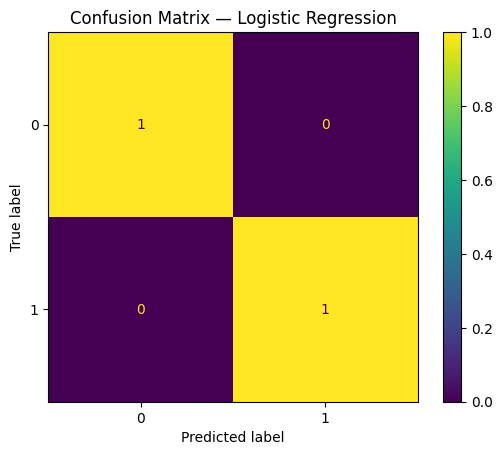


Top 'Real' indicators:
[('water', np.float64(0.1337055083337276)), ('water on', np.float64(0.1337055083337276)), ('mars', np.float64(0.1337055083337276)), ('on mars', np.float64(0.1337055083337276)), ('on', np.float64(0.1337055083337276)), ('scientists', np.float64(0.1337055083337276)), ('scientists discover', np.float64(0.1337055083337276)), ('discover water', np.float64(0.1337055083337276)), ('discover', np.float64(0.1337055083337276)), ('plan', np.float64(0.12094118278546676)), ('healthcare reform', np.float64(0.12094118278546676)), ('announces new', np.float64(0.12094118278546676)), ('announces', np.float64(0.12094118278546676)), ('new', np.float64(0.12094118278546676)), ('new healthcare', np.float64(0.12094118278546676))]

Top 'Fake' indicators:
[('claim', np.float64(-0.11124970756366905)), ('claim within', np.float64(-0.11124970756366905)), ('hours', np.float64(-0.11124970756366905)), ('lottery', np.float64(-0.11124970756366905)), ('of claim', np.float64(-0.11124970756366905)), 

In [6]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
_ = plt.title("Confusion Matrix — Logistic Regression")
plt.show()

# Top indicative features
feature_names = np.array(tfidf.get_feature_names_out())
coef = clf.coef_[0]
top_pos = np.argsort(coef)[-15:][::-1]  # real
top_neg = np.argsort(coef)[:15]         # fake

print("\nTop 'Real' indicators:")
print(list(zip(feature_names[top_pos], coef[top_pos])))
print("\nTop 'Fake' indicators:")
print(list(zip(feature_names[top_neg], coef[top_neg])))

## 6) Save Model & Vectorizer (for Streamlit app)

In [7]:
joblib.dump(clf, 'fake_news_lr.joblib')
joblib.dump(tfidf, 'tfidf.joblib')
print("Saved: fake_news_lr.joblib, tfidf.joblib")

Saved: fake_news_lr.joblib, tfidf.joblib


In [ ]:
from google.colab import files
files.upload()  # upload streamlit_fake_news_app.py, fake_news_lr.joblib, tfidf.joblib if needed
!pip -q install streamlit==1.36.0 pyngrok==7.0.0
from pyngrok import ngrok
public_url = ngrok.connect(8501).public_url
print("Public URL:", public_url)
!streamlit run streamlit_fake_news_app.py --server.port 8501 --server.headless true


Saving tfidf.joblib to tfidf (1).joblib
Saving fake_news_lr.joblib to fake_news_lr (1).joblib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.11.0 requires watchdog<7.0.0,>=6.0.0, but you have watchdog 4.0.2 which is incompatible.


ERROR:pyngrok.process.ngrok:t=2025-08-25T11:30:06+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-08-25T11:30:06+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-08-25T11:30:06+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.